In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import imblearn

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix


/Users/tonbadal/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/tonbadal/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [26]:
# Set the style of plots
plt.style.use('seaborn')
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.alpha'] = 0.1

mpl.rcParams['axes.linewidth'] = 0.3
mpl.rcParams['axes.edgecolor'] = 'grey'

mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

In [208]:
data = pd.read_csv('/Users/tonbadal/PycharmProjects/synthesized/docs/kernels/give-me-some-credit/data/cs-training.csv')


In [4]:
data.head(10)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                 1                              0.766127   45   
1                 0                              0.957151   40   
2                 0                              0.658180   38   
3                 0                              0.233810   30   
4                 0                              0.907239   49   
5                 0                              0.213179   74   
6                 0                              0.305682   57   
7                 0                              0.754464   39   
8                 0                              0.116951   27   
9                 0                              0.189169   57   

   NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
0                                     2     0.802982         9120.0   
1                                     0     0.121876         2600.0   
2                                     1     0.085113         3042.0   
3                                     0     0.036050         3300.0   
4                                     1     0.024926        63588.0   
5                                     0     0.375607         3500.0   
6                                     0  5710.000000            NaN   
7                                     0     0.209940         3500.0   
8                                     0    46.000000            NaN   
9                                     0     0.606291        23684.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        1   
3                                5                        0   
4                                7                        0   
5                                3                        0   
6                                8                        0   
7                                8                        0   
8                                2                        0   
9                                9                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             6                                     0   
1                             0                                     0   
2                             0                                     0   
3                             0                                     0   
4                             1                                     0   
5                             1                                     0   
6                             3                                     0   
7                             0                                     0   
8                             0                                     0   
9                             4                                     0   

   NumberOfDependents  
0                 2.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 0.0  
5                 1.0  
6                 0.0  
7                 0.0  
8                 NaN  
9                 2.0

In [213]:
train, test = train_test_split(data.copy().dropna(), test_size=0.2)

target = 'SeriousDlqin2yrs'
features = list(filter(lambda c: c != target, data.columns))

X_train, y_train = train[features].values, train[target].values
X_test, y_test = test[features].values, test[target].values

In [6]:
classifiers = {
    'LogisticRegression': LogisticRegression(), 
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

scores = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1': f1_score,
    'AUC': roc_auc_score
}

for name, clf in classifiers.items():
    print(name, hasattr(clf, 'predict_proba'))

LogisticRegression True
RandomForest True
XGBoost True


In [7]:
train.groupby(target).count()['age'] / len(train)

SeriousDlqin2yrs
0    0.930468
1    0.069532
Name: age, dtype: float64

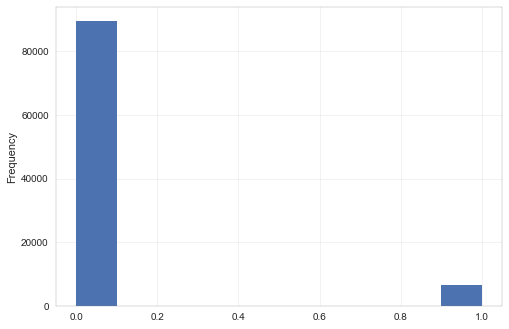

In [8]:
train[target].plot.hist()

In [9]:
def classification(X_train, y_train, X_test, y_test, classifiers, name, results=None):
    
    if results is None:
        results = dict()
    
    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        if hasattr(clf, 'predict_proba'):
            f_prob_train = clf.predict_proba(X_train).T[1]
            f_train = [0 if p < 0.5 else 1 for p in f_prob_train]
            f_prob_test = clf.predict_proba(X_test).T[1]
            f_test = [0 if p < 0.5 else 1 for p in f_prob_test]
            
        else:
            f_prob_train = f_train = clf.predict(X_train)
            f_prob_test = f_test = clf.predict(X_test)
                   
#         for score_name, fn_score in scores:
#             results['{}_{}'.format(clf_name, name)][score_name] = 
        
        results['{}_{}'.format(clf_name, name)] = {
            'Accuracy Train': accuracy_score(y_train, f_train),
            'Precision Train': precision_score(y_train, f_train),
            'Recall Train': recall_score(y_train, f_train),
            'F1 Train': f1_score(y_train, f_train),
            'AUC Train': roc_auc_score(y_train, f_prob_train),
            
            'Accuracy Test': accuracy_score(y_test, f_test),
            'Precision Test': precision_score(y_test, f_test),
            'Recall Test': recall_score(y_test, f_test),
            'F1 Test': f1_score(y_test, f_test),
            'AUC Test': roc_auc_score(y_test, f_prob_test),
            
            'ROC Curve': roc_curve(y_test, f_prob_test),
            'PR Curve': precision_recall_curve(y_test, f_prob_test)
#             'Confusion Matrix': confusion_matrix(y_test, f_test)
        }
    return results
        

Random majority under-sampling with replacement
Random minority over-sampling with replacement

Balanced Bagging
Balanced Random Forest

SMOTE
ADASYN

Synthesized

In [10]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

ru_sampler = RandomUnderSampler()
X_rus, y_rus = ru_sampler.fit_sample(X_train, y_train)

ro_sampler = RandomOverSampler()
X_ros, y_ros = ro_sampler.fit_sample(X_train, y_train)
 
smote = SMOTE()
X_smote, y_smote = smote.fit_sample(X_train, y_train)

In [30]:
for i in range(len(X_train)):
    if not all(X_smote[i] == X_train[i]):
        print(i)
        break

In [31]:
i

96214

In [38]:
print(X_train.shape)
print(X_smote.shape)
print(X_smote[:len(X_train)].shape)
print(X_smote[len(X_train):].shape)

y_smote[len(y_train):]
X_train

(96215, 10)
(179050, 10)
(96215, 10)
(82835, 10)


array([1, 1, 1, ..., 1, 1, 1])

In [80]:
print(X_train.shape)
print(y_train.reshape(-1,1).shape)

print(train[~train.duplicated()].shape)


train2 = train[~train.duplicated()]

X_train, y_train = train2[features].values, train2[target].values

smote = SMOTE()
X_smote, y_smote = smote.fit_sample(X_train, y_train)

print(sum(pd.DataFrame(np.hstack((X_smote, y_smote.reshape(-1, 1)))).duplicated()))



(96136, 10)
(96136, 1)
(96136, 11)
0


In [54]:
for i in range(len(X_smote[len(X_train):])):
    x = X_smote[len(X_train)+1:][i]
    if x in X_train:
        print('sample {} found in X_train'.format(i))
        break

sample 0 found in X_train


In [ ]:
X_smote[len(X_train)]

In [ ]:
data_synth = pd.read_csv('/Users/tonbadal/PycharmProjects/synthesized/docs/kernels/give-me-some-credit/data/cs-training-rebalanced.csv').sample(frac=0.64)
train_synth = pd.concat((train, data_synth))
X_synth, y_synth = train_synth[features].values, train_synth[target].values

train_synth[target].plot.hist()


In [ ]:
results = dict()

results = classification(X_train, y_train, X_test, y_test, classifiers, name='NoResampling', results=results)
# results = classification(X_rus, y_rus, X_test, y_test, classifiers, name='RandomUnderSampler', results=results)
# results = classification(X_ros, y_ros, X_test, y_test, classifiers, name='RandomOverSampler', results=results)
# results = classification(X_smote, y_smote, X_test, y_test, classifiers, name='SMOTE', results=results)
# results = classification(X_synth, y_synth, X_test, y_test, classifiers, name='Synthesized', results=results)

df_results = pd.DataFrame(results)
df_results

In [ ]:
df_results = pd.DataFrame(results)
df_results

In [ ]:
fig, (ax_lr, ax_rf, ax_xgb) = plt.subplots(3, 2, figsize=(20, 30), sharex=True, sharey=True)


axs = {'LogisticRegression': ax_lr, 
      'RandomForest': ax_rf,
      'XGBoost': ax_xgb}

for c in df_results.columns:
    clf_name, tech = c.split('_')
    
    fpr, tpr, thresholds = df_results[c]['ROC Curve']
    auc_ = df_results[c]['AUC Test']
    axs[clf_name][0].plot(fpr, tpr, label='{} (AUC={:.3f})'.format(tech, auc_))
    
    prec, rec, thresholds = df_results[c]['PR Curve']
    f1_ = df_results[c]['F1 Test']
    axs[clf_name][1].plot(rec, prec, label='{} (F1={:.3f})'.format(tech, f1_))

for name, ax in axs.items():
    ax[0].set_xlabel('FPR')
    ax[0].set_ylabel('FPR')
    ax[0].plot([0,1], [0,1], 'k:')
    ax[0].set_title('ROC Curve: ' + name)
    ax[0].legend()
    
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('PR Curve: ' + name)
    ax[1].legend()
    
plt.savefig('ROC_PR_Curves.pdf', fmt='pdf')

# Privacy preserving approach

In [ ]:
data = pd.read_csv('/Users/tonbadal/PycharmProjects/synthesized/docs/kernels/give-me-some-credit/data/cs-training.csv')
train, test = train_test_split(data.dropna(), test_size=0.2)

target = 'SeriousDlqin2yrs'
features = list(filter(lambda c: c != target, data.columns))

X_train, y_train = train[features].values, train[target].values

In [112]:
X_smote0

array([[1.72547554e-01, 3.50000000e+01, 0.00000000e+00, ...,
        1.73184766e+00, 0.00000000e+00, 0.00000000e+00],
       [5.04376010e-01, 3.29555996e+01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.57394861e-01, 3.60588588e+01, 0.00000000e+00, ...,
        5.88587641e-02, 0.00000000e+00, 1.94114124e+00],
       ...,
       [8.72351905e-02, 6.72384358e+01, 0.00000000e+00, ...,
        2.00000000e+00, 0.00000000e+00, 2.38435817e-01],
       [6.05366023e-01, 4.32419424e+01, 0.00000000e+00, ...,
        1.62097121e+00, 0.00000000e+00, 2.75805759e+00],
       [2.73568168e-01, 6.05455012e+01, 0.00000000e+00, ...,
        8.18251825e-01, 0.00000000e+00, 7.27249392e-01]])

In [119]:
num0 = 75000

X_train0 = X_train[y_train == 0]

len_x = len(X_train0)

X_train0 = np.vstack(( X_train0, np.zeros((len_x + num0, 10)) ))

y_train0 = np.hstack(( np.zeros(len_x), np.ones(len_x + num0) ))

smote = SMOTE()
X_smote0, _ = smote.fit_sample(X_train0, y_train0)
X_smote0 = X_smote0[-num0:]

print(X_smote0.shape)

########################################

num1 = 75000

X_train1 = X_train[y_train == 1]

len_x = len(X_train1)

X_train1 = np.vstack(( X_train1, np.zeros((len_x + num1, 10)) ))
y_train1 = np.hstack(( np.ones(len_x), np.zeros(len_x + num1) ))

smote = SMOTE()
X_smote1, _ = smote.fit_sample(X_train1, y_train1)
X_smote1 = X_smote1[-num1:]

print(X_smote1.shape)

(75000, 10)
(75000, 10)


In [120]:
X_smote = np.vstack((X_smote0, X_smote1))
y_smote = np.hstack((np.zeros(num), np.ones(num)))

print(X_smote.shape)
print(y_smote.shape)

(150000, 10)
(150000,)


In [127]:
data_smote = pd.DataFrame(np.hstack((X_smote, y_smote.reshape(-1, 1))))

In [121]:

data_synth = pd.read_csv('/Users/tonbadal/PycharmProjects/synthesized/docs/kernels/give-me-some-credit/data/cs-training-synthesized.csv')
data_synth_rebalanced = pd.read_csv('/Users/tonbadal/PycharmProjects/synthesized/docs/kernels/give-me-some-credit/data/cs-training-rebalanced_50-50.csv')


X_synth, y_synth = data_synth[features].values, data_synth[target].values
X_synth_reb, y_synth_reb = data_synth_rebalanced[features].values, data_synth_rebalanced[target].values
print(len(X_synth_reb))

X_test, y_test = test[features].values, test[target].values


150000


In [122]:
results = dict()

results = classification(X_train, y_train, X_test, y_test, classifiers, name='Original', results=results)
results = classification(X_synth, y_synth, X_test, y_test, classifiers, name='Synthesized', results=results)
results = classification(X_synth_reb, y_synth_reb, X_test, y_test, classifiers, name='Synthesized Resampled', results=results)
results = classification(X_smote, y_smote, X_test, y_test, classifiers, name='SMOTE Resampled', results=results)

df_results = pd.DataFrame(results)
df_results

/Users/tonbadal/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tonbadal/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/tonbadal/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tonbadal/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tonbadal

LogisticRegression_Original  \
Accuracy Train                                            0.930692   
Precision Train                                           0.540984   
Recall Train                                             0.0246711   
F1 Train                                                   0.04719   
AUC Train                                                 0.681441   
Accuracy Test                                             0.931113   
Precision Test                                            0.560976   
Recall Test                                              0.0275945   
F1 Test                                                  0.0526015   
AUC Test                                                  0.697166   
ROC Curve        ([0.0, 0.0, 0.0, 4.466878098896681e-05, 4.4668...   
PR Curve         ([0.06938605619146722, 0.06934731934731934, 0....   

                                             RandomForest_Original  \
Accuracy Train                                            0.996006   
Precision Train                                            0.98657   
Recall Train                                              0.955592   
F1 Train                                                  0.970834   
AUC Train                                                 0.999674   
Accuracy Test                                             0.927247   
Precision Test                                            0.456816   
Recall Test                                               0.263347   
F1 Test                                                   0.334094   
AUC Test                                                  0.783474   
ROC Curve        ([0.0, 0.00013400634296690042, 0.0007147004958...   
PR Curve         ([0.06930240292674815, 0.1563352343168857, 0.2...   

                                                  XGBoost_Original  \
Accuracy Train                                            0.935581   
Precision Train                                           0.624185   
Recall Train                                              0.186005   
F1 Train                                                  0.286603   
AUC Train                                                  0.85934   
Accuracy Test                                              0.93498   
Precision Test                                            0.598848   
Recall Test                                               0.187163   
F1 Test                                                   0.285192   
AUC Test                                                  0.863294   
ROC Curve        ([0.0, 0.0, 0.0, 4.466878098896681e-05, 4.4668...   
PR Curve         ([0.06945543935669347, 0.069818120861621, 0.06...   

                                    LogisticRegression_Synthesized  \
Accuracy Train                                             0.92892   
Precision Train                                           0.639775   
Recall Train                                             0.0315419   
F1 Train                                                 0.0601199   
AUC Train                                                 0.678907   
Accuracy Test                                             0.929949   
Precision Test                                            0.367647   
Recall Test                                               0.014997   
F1 Test                                                  0.0288184   
AUC Test                                                  0.636132   
ROC Curve        ([0.0, 8.933756197793362e-05, 0.00044668780988...   
PR Curve         ([0.06947280683475725, 0.0694340251729599, 0.0...   

                                          RandomForest_Synthesized  \
Accuracy Train                                            0.997787   
Precision Train                                           0.985454   
Recall Train                                              0.983813   
F1 Train                                                  0.984632   
AUC Train                                    

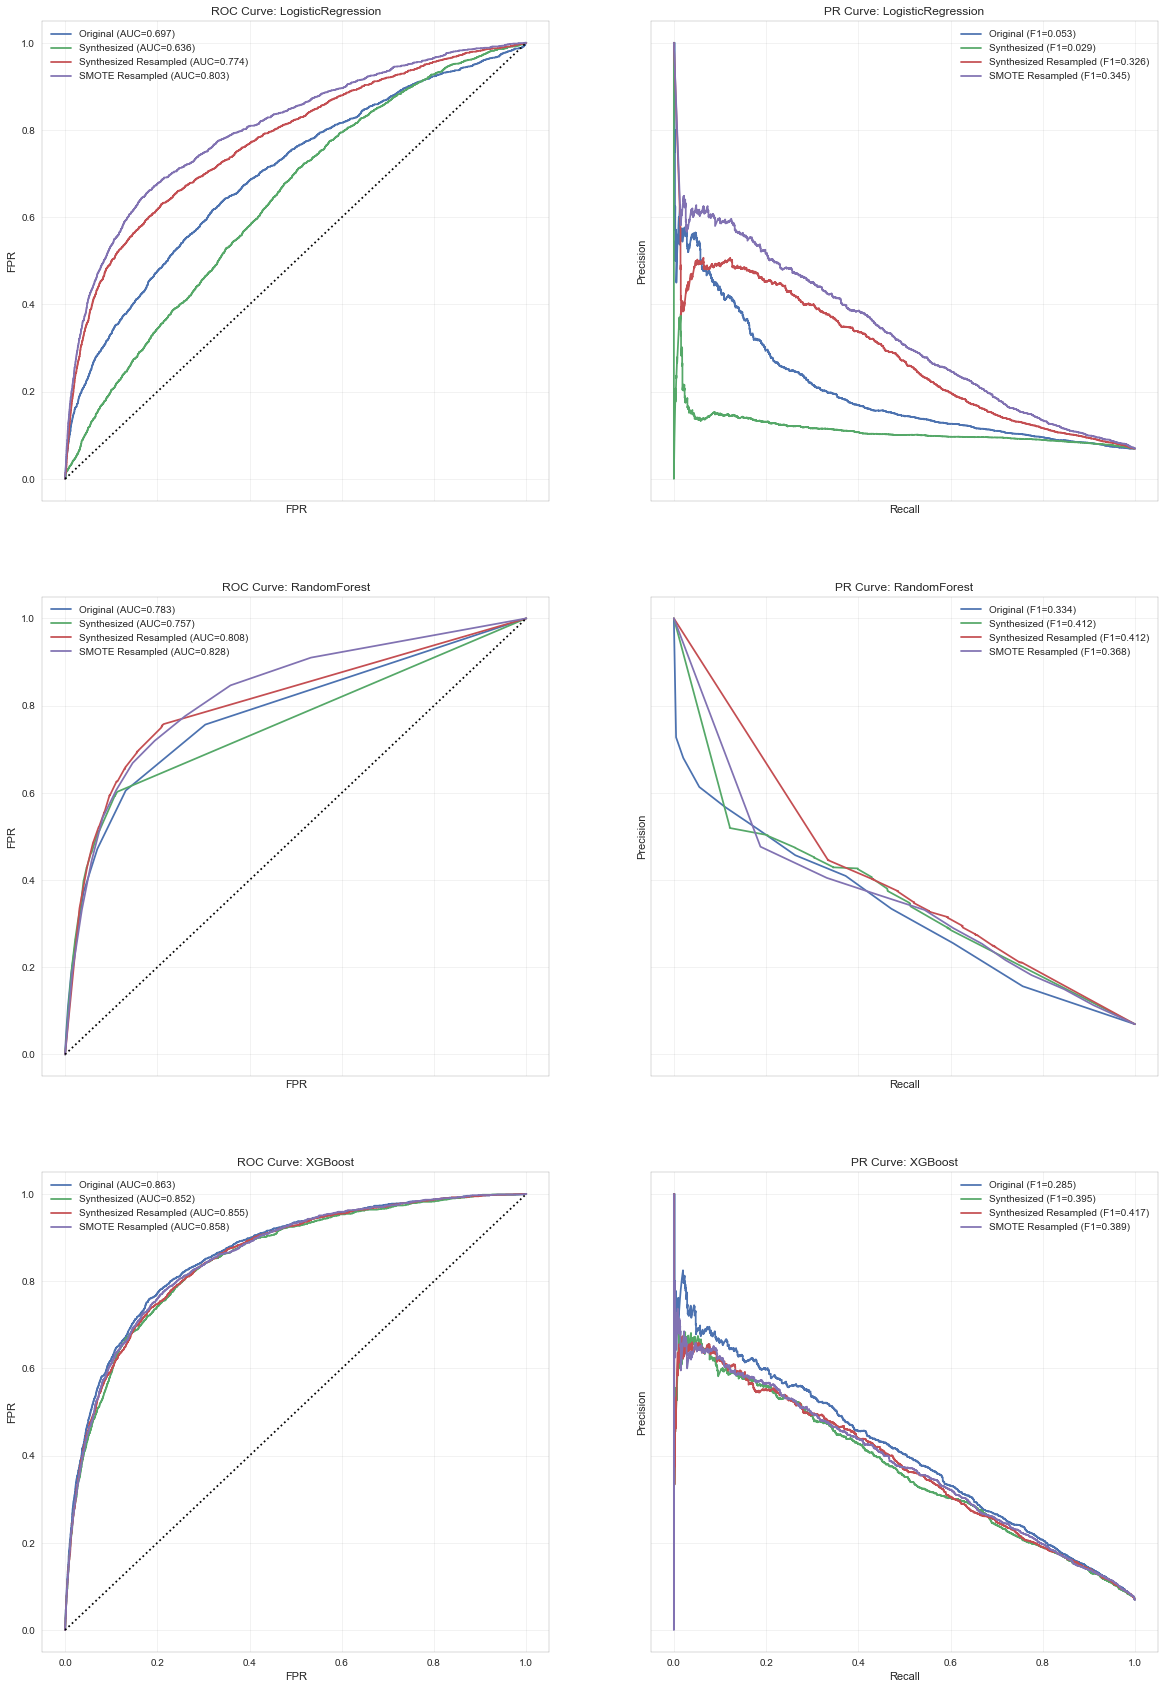

In [123]:
fig, (ax_lr, ax_rf, ax_xgb) = plt.subplots(3, 2, figsize=(20, 30), sharex=True, sharey=True)


axs = {'LogisticRegression': ax_lr, 
      'RandomForest': ax_rf,
      'XGBoost': ax_xgb}

for c in df_results.columns:
    clf_name, tech = c.split('_')
    
    fpr, tpr, thresholds = df_results[c]['ROC Curve']
    auc_ = df_results[c]['AUC Test']
    axs[clf_name][0].plot(fpr, tpr, label='{} (AUC={:.3f})'.format(tech, auc_))
    
    prec, rec, thresholds = df_results[c]['PR Curve']
    f1_ = df_results[c]['F1 Test']
    axs[clf_name][1].plot(rec, prec, label='{} (F1={:.3f})'.format(tech, f1_))

for name, ax in axs.items():
    ax[0].set_xlabel('FPR')
    ax[0].set_ylabel('FPR')
    ax[0].plot([0,1], [0,1], 'k:')
    ax[0].set_title('ROC Curve: ' + name)
    ax[0].legend()
    
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('PR Curve: ' + name)
    ax[1].legend()
    
plt.savefig('ROC_PR_Curves_privacy.pdf', fmt='pdf')

In [131]:
data.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                 1                              0.766127   45   
1                 0                              0.957151   40   
2                 0                              0.658180   38   
3                 0                              0.233810   30   
4                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        1   
3                                5                        0   
4                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             6                                     0   
1                             0                                     0   
2                             0                                     0   
3                             0                                     0   
4                             1                                     0   

   NumberOfDependents  
0                 2.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 0.0

In [133]:
print(sum(train['SeriousDlqin2yrs']==0))
print(sum(train['SeriousDlqin2yrs']==1))

89525
6690


In [325]:
def get_smote(train, target):
    
    target = 'SeriousDlqin2yrs'
    features = list(filter(lambda c: c != target, data.columns))

    X_train, y_train = train[features].values, train[target].values

    num0 = sum(train['SeriousDlqin2yrs']==0)
    X_train0 = X_train[y_train == 0]
    len_x = len(X_train0)
    X_train0 = np.vstack(( X_train0, np.zeros((len_x + num0, 10)) ))
    y_train0 = np.hstack(( np.zeros(len_x), np.ones(len_x + num0) ))

    smote = SMOTE()
    X_smote0, _ = smote.fit_sample(X_train0, y_train0)
    X_smote0 = X_smote0[-num0:]

    ########################################

    num1 = sum(train['SeriousDlqin2yrs']==1)
    X_train1 = X_train[y_train == 1]
    len_x = len(X_train1)
    X_train1 = np.vstack(( X_train1, np.zeros((len_x + num1, 10)) ))
    y_train1 = np.hstack(( np.ones(len_x), np.zeros(len_x + num1) ))

    smote = SMOTE()
    X_smote1, _ = smote.fit_sample(X_train1, y_train1)
    X_smote1 = X_smote1[-num1:]

    ########################################

    X_smote = np.vstack((X_smote0, X_smote1))
    y_smote = np.hstack((np.zeros(num0), np.ones(num1)))

    data_smote = pd.DataFrame(np.hstack((y_smote.reshape(-1, 1), X_smote)), columns=train.columns)
    for c in train.columns:
        if train[c].dtype == 'int64':
            data_smote[c] = data_smote[c].apply(round).astype('int64')

    return data_smote

In [299]:
data_smote = pd.DataFrame(np.hstack((y_smote.reshape(-1, 1), X_smote)), columns=train.columns)
for c in train.columns:
    if train[c].dtype == 'int64':
        data_smote[c] = data_smote[c].astype('int64')

Average distance: 0.03601320978201139
Max distance: 0.161546200600321


/Users/tonbadal/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/tonbadal/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


Average distance: 0.008867270445179824
Max distance: 0.06192897865374157


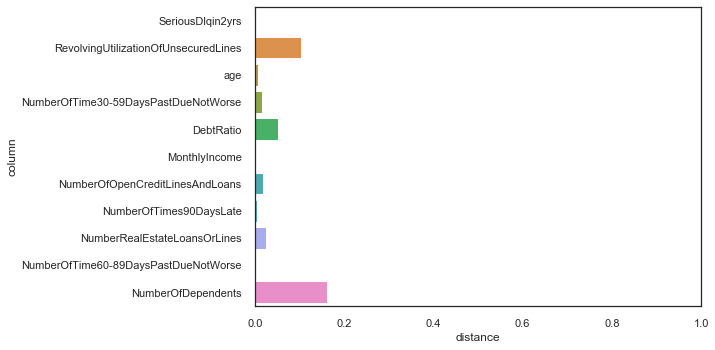

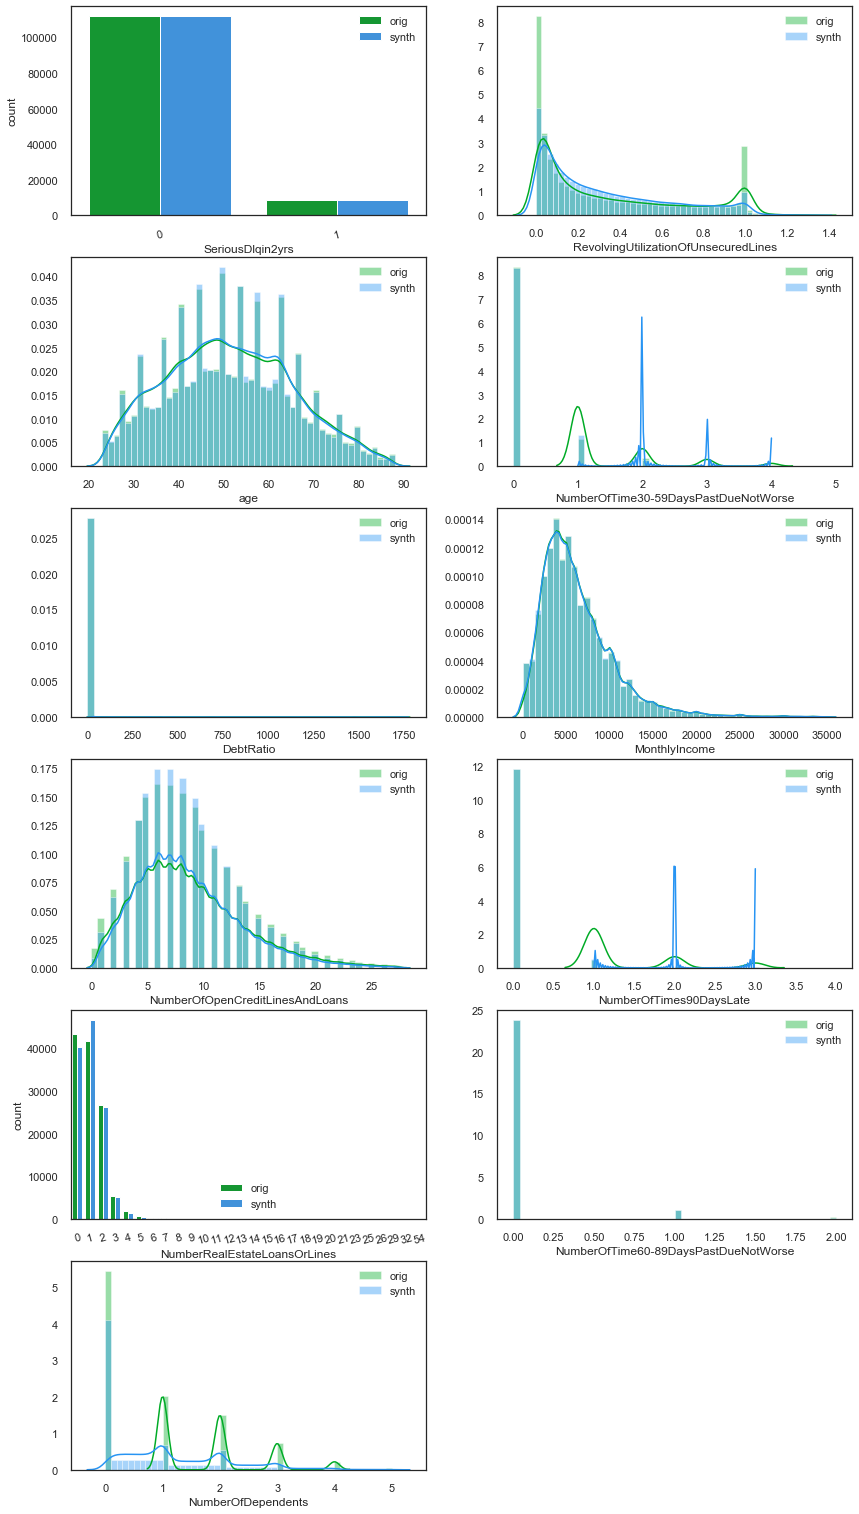

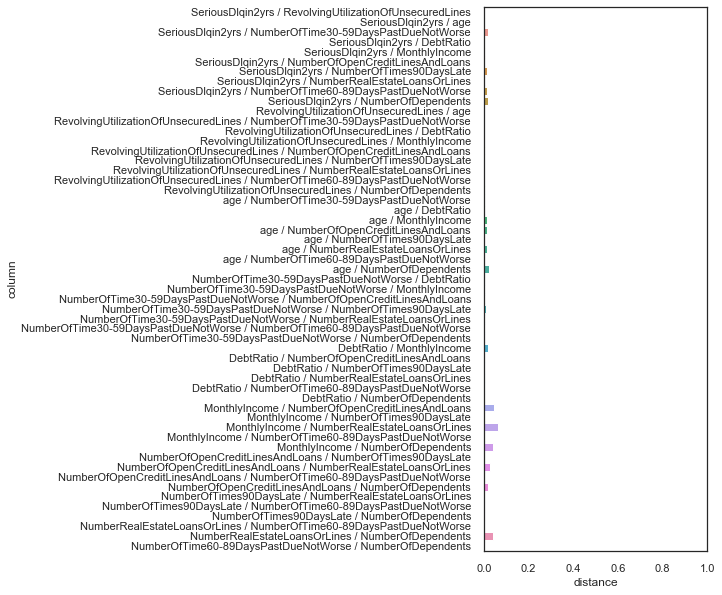

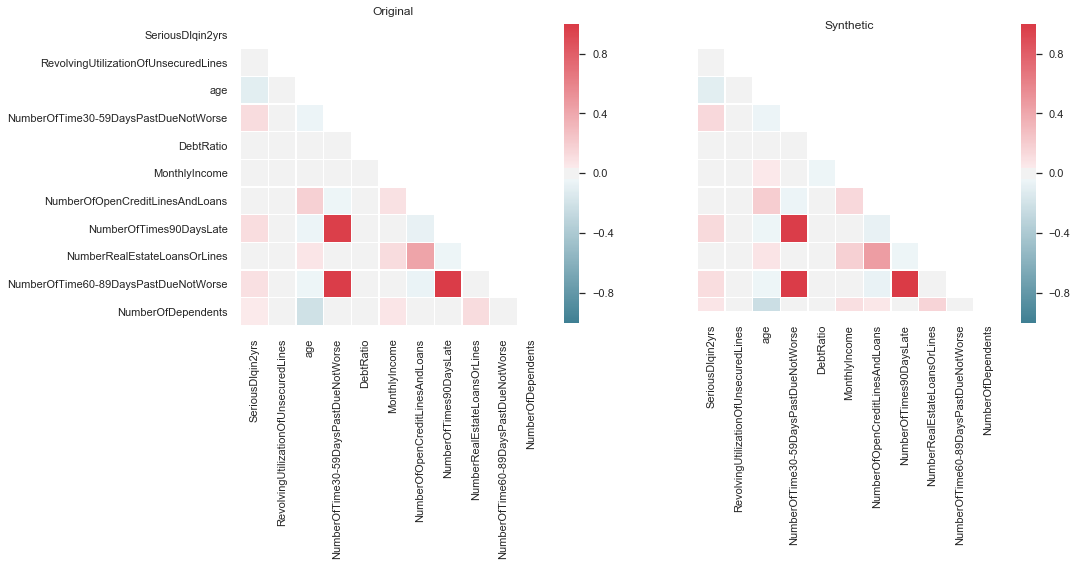

In [386]:
from synthesized import HighDimSynthesizer
from synthesized.testing import UtilityTesting

data = pd.read_csv('/Users/tonbadal/PycharmProjects/synthesized/docs/kernels/give-me-some-credit/data/cs-training.csv')
data = data.dropna()

data_smote = get_smote(data, target=target)

synthesizer = HighDimSynthesizer(df=pd.concat((data, data_smote)))
synthesizer.__enter__()

testing = UtilityTesting(synthesizer, data, data, data_smote)

testing.show_distribution_distances()
testing.show_distributions(remove_outliers=0.01)
testing.show_corr_distances()
testing.show_corr_matrices()


Average distance: 0.061592989654252334
Max distance: 0.3245807315268274


/Users/tonbadal/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/tonbadal/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


Average distance: 0.07352351341476705
Max distance: 0.9199235414663668


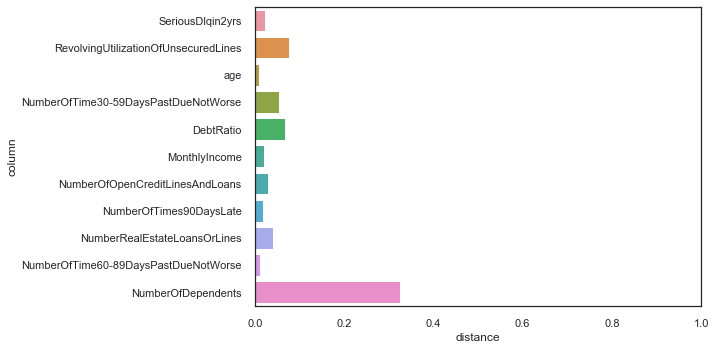

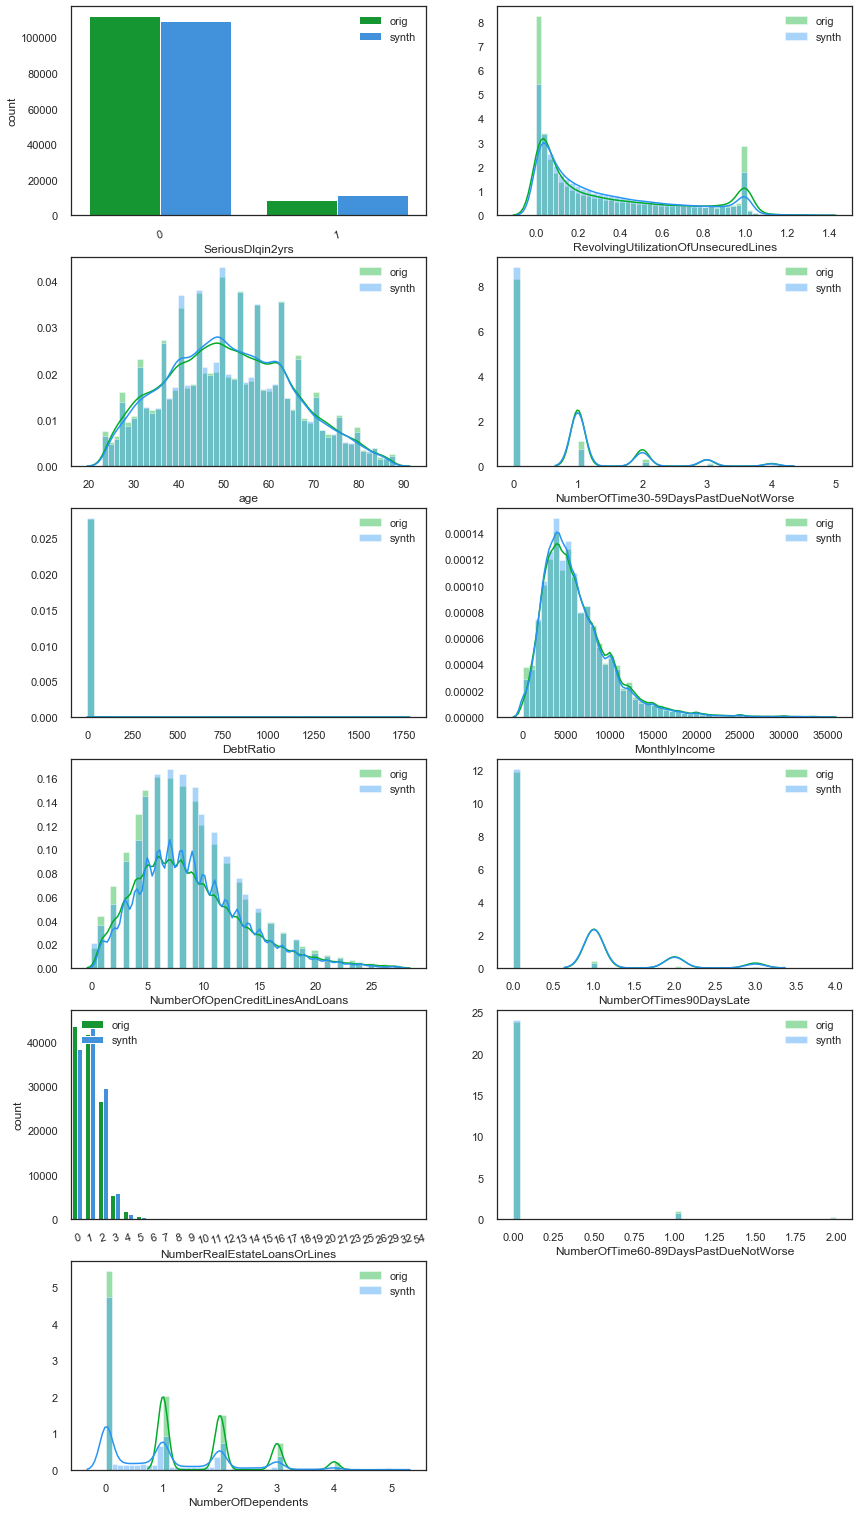

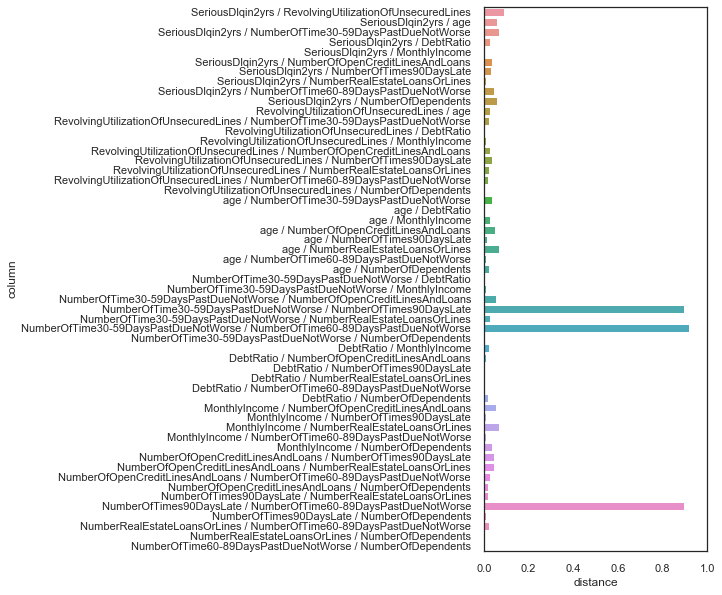

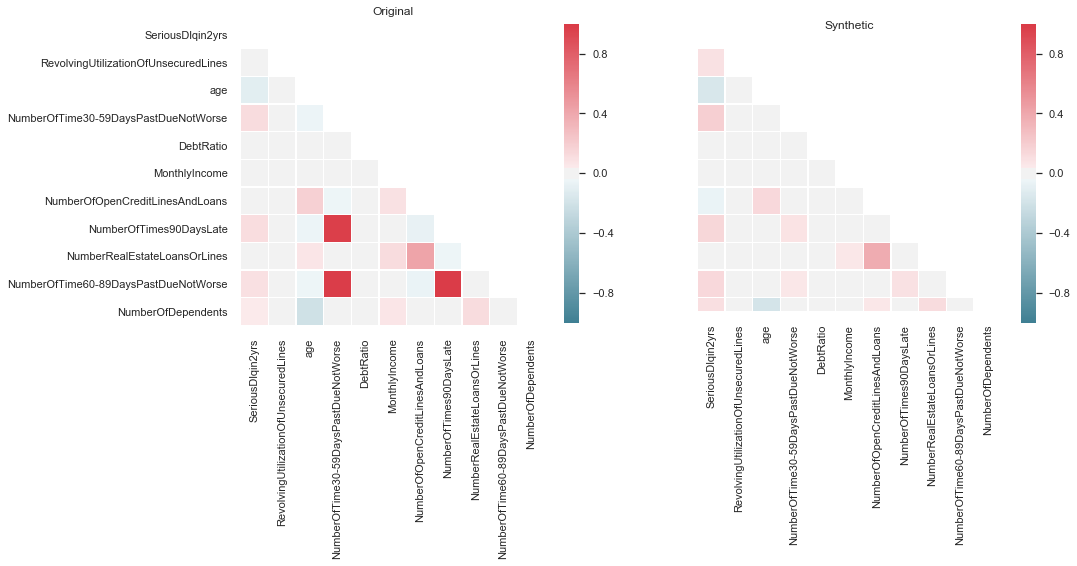

In [387]:
from synthesized import HighDimSynthesizer
from synthesized.testing import UtilityTesting

data = pd.read_csv('/Users/tonbadal/PycharmProjects/synthesized/docs/kernels/give-me-some-credit/data/cs-training.csv')

data = data.dropna()
data_smote = get_smote(data.dropna(), target=target)

data_concat = pd.concat((data, data_smote))
synthesizer = HighDimSynthesizer(df=data_concat)
synthesizer.__enter__()
synthesizer.learn(df_train=data_concat, num_iterations=5000)
synthesized = synthesizer.synthesize(num_rows=len(data))

testing = UtilityTesting(synthesizer, data, data, synthesized)

testing.show_distribution_distances()
testing.show_distributions(remove_outliers=0.01)
testing.show_corr_distances()
testing.show_corr_matrices()


# Resampling plots

In [7]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
                                    KMeansSMOTE)
from imblearn.over_sampling import RandomOverSampler
from imblearn.base import BaseSampler


In [8]:
def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

In [35]:
def plot_resampling(X, y, sampling=None, ax=None):
    if sampling:
        X_res, y_res = sampling.fit_resample(X, y)
    else:
        X_res, y_res = X, y
    if not ax:
        _, ax = plt.subplots(1)
        
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

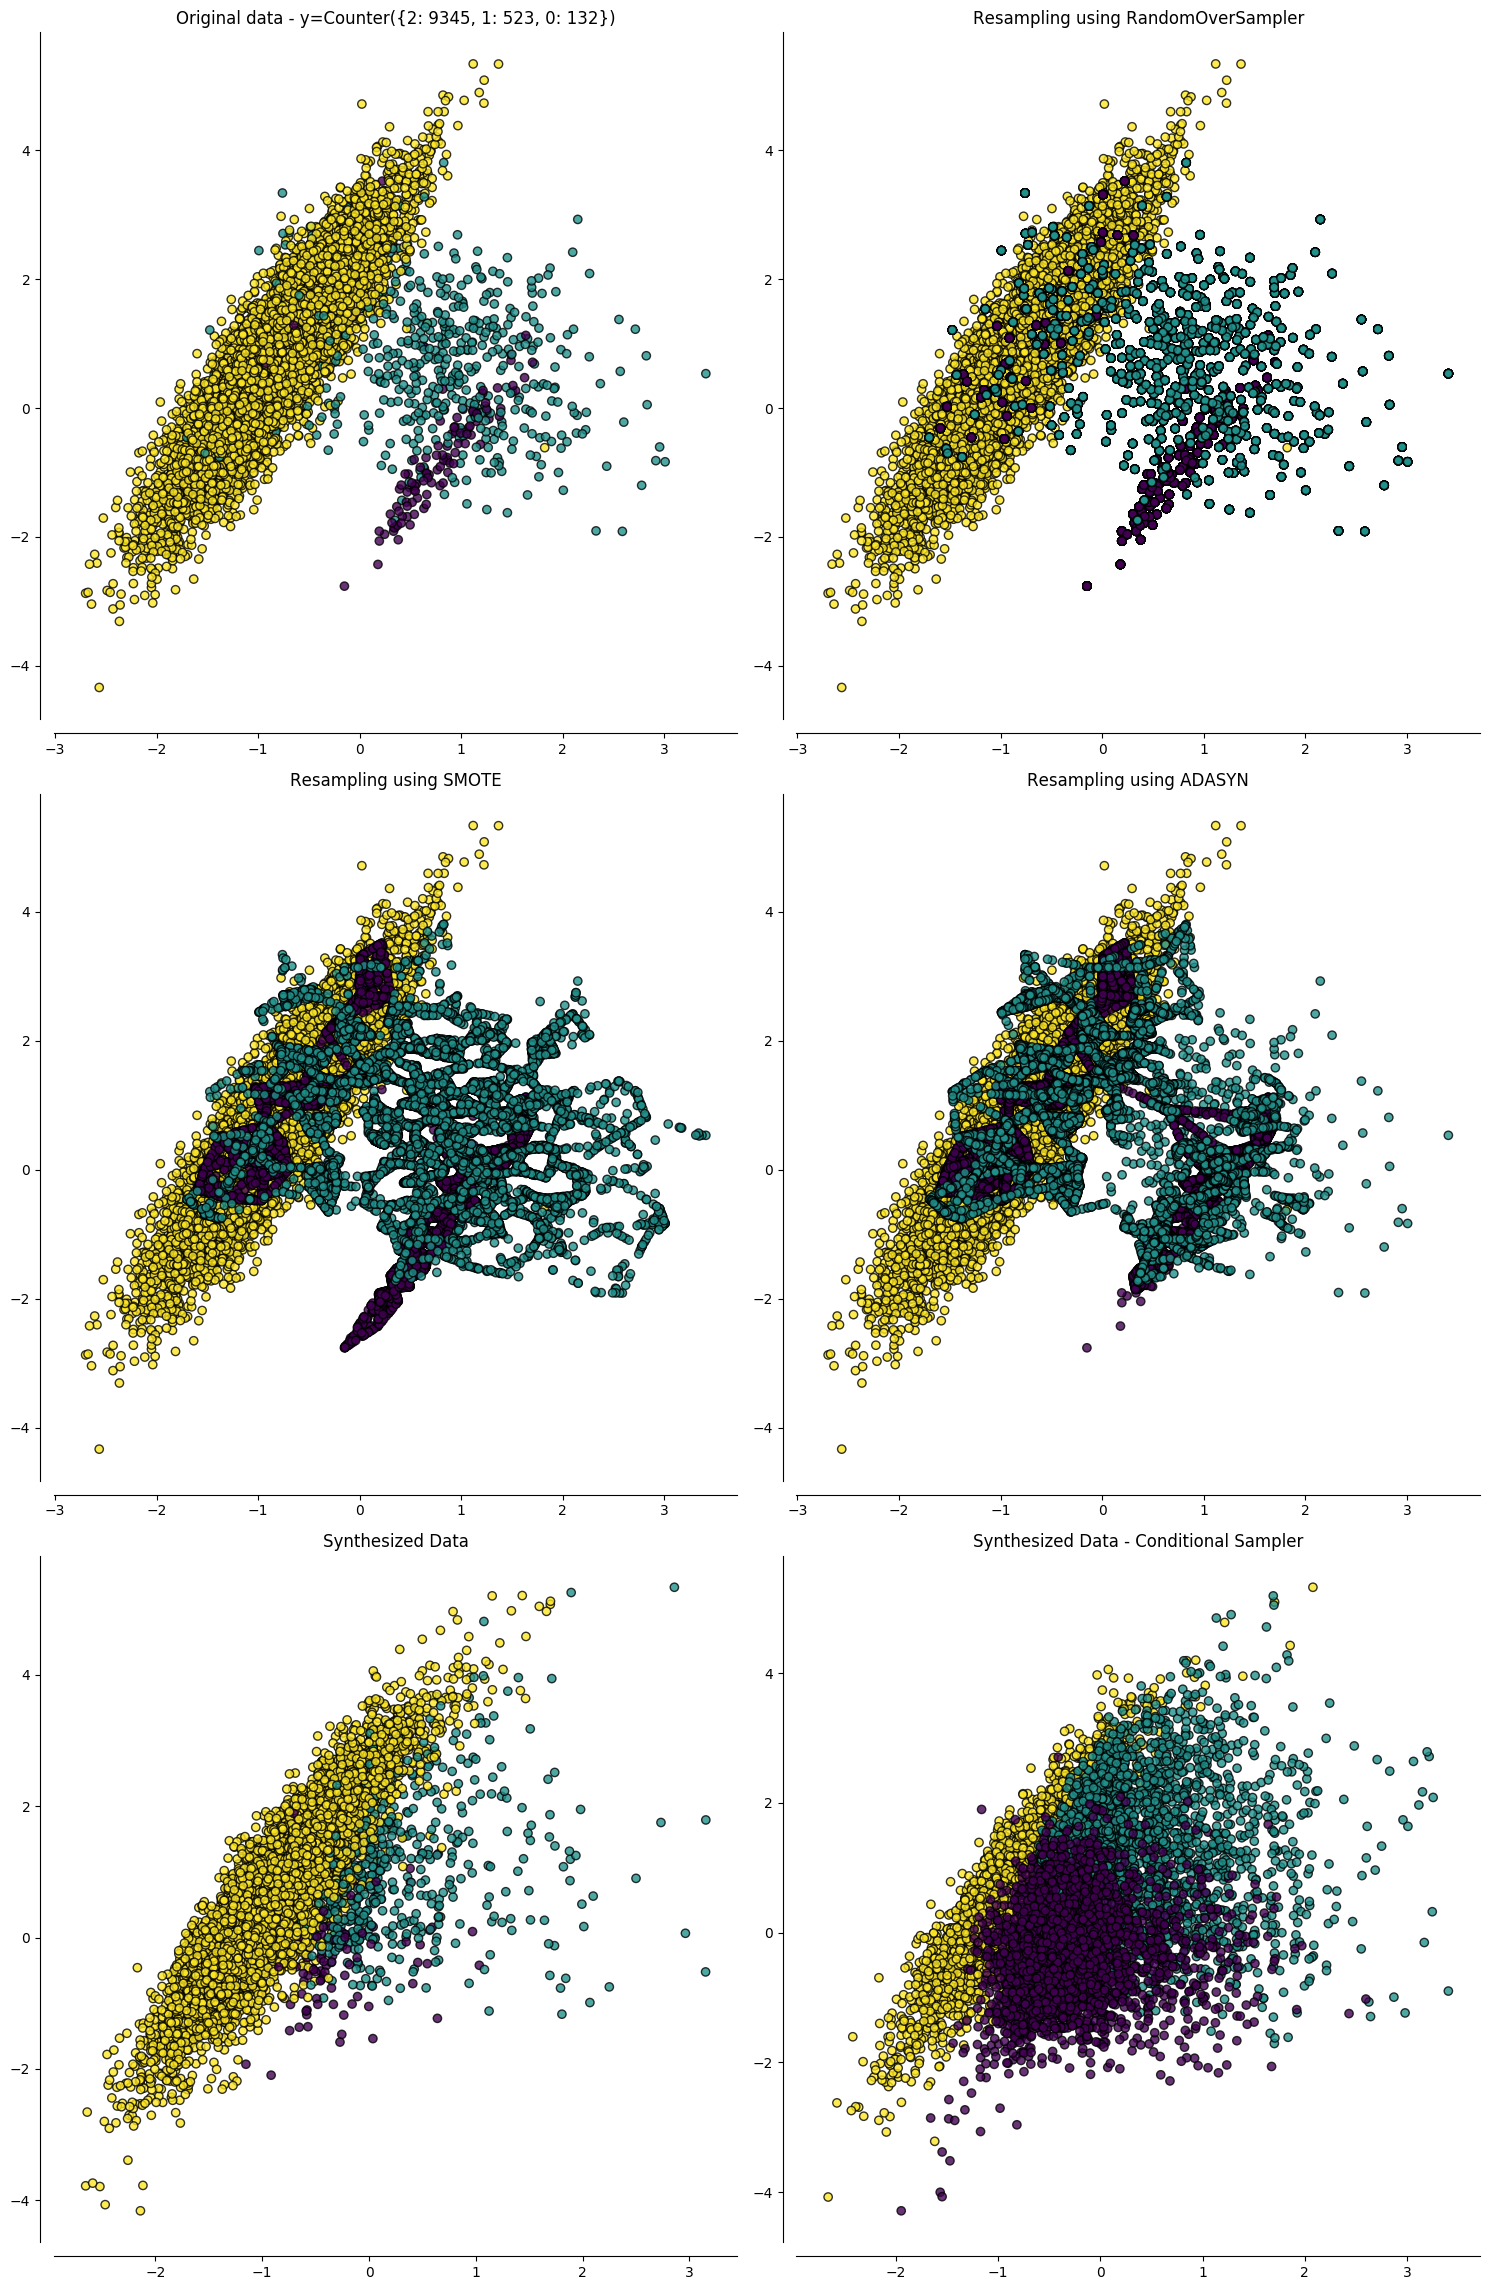

In [45]:
class FakeSampler(BaseSampler):

    _sampling_type = 'bypass'

    def _fit_resample(self, X, y):
        return X, y


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 23))
X, y = create_dataset(n_samples=1000, weights=(0.01, 0.05, 0.94))
sampler = FakeSampler()
clf = make_pipeline(sampler, LinearSVC())
plot_resampling(X, y, sampler, ax1)
ax1.set_title('Original data - y={}'.format(Counter(y)))

ax_arr = (ax2, ax3, ax4)
for ax, sampler in zip(ax_arr, (RandomOverSampler(random_state=0),
                                SMOTE(random_state=0),
                                ADASYN(random_state=0))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_resampling(X, y, sampler, ax)
    ax.set_title('Resampling using {}'.format(sampler.__class__.__name__))

    
## Synthesized
data = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))), 
                    columns=['x1', 'x2', 'y'])

synthesizer = HighDimSynthesizer(df=data)
synthesizer.__enter__()
synthesizer.learn(df_train=data, num_iterations=10000)
synthesized = synthesizer.synthesize(num_rows=len(data))

conditional_sampler = ConditionalSampler(synthesizer, ('y', {'0.0': 0.34, '1.0': 0.33, '2.0': 0.33}))
synthesized_cond = conditional_sampler.synthesize(num_rows=len(data.dropna()))

X_synth, y_synth = synthesized[['x1', 'x2']].values, synthesized['y'].values
X_synth_cond, y_synth_cond = synthesized_cond[['x1', 'x2']].values, synthesized_cond['y'].values

plot_resampling(X_synth, y_synth, ax=ax5)
ax5.set_title('Synthesized Data')

plot_resampling(X_synth_cond, y_synth_cond, ax=ax6)
ax6.set_title('Synthesized Data - Conditional Sampler')
    
fig.tight_layout()
plt.savefig('/Users/tonbadal/PycharmProjects/synthesized/docs/DS experiments/resampling/resampling.pdf', format='pdf')


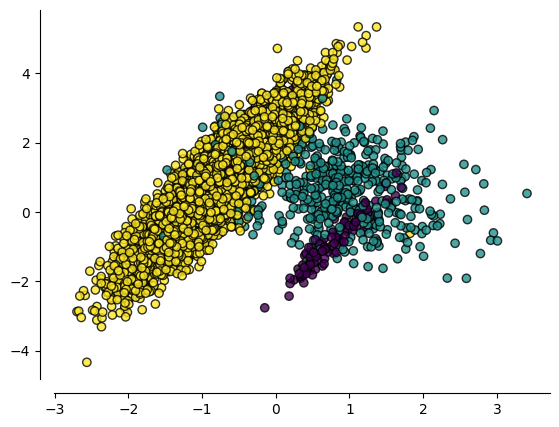

In [42]:
X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))
plot_resampling(X, y)
plt.savefig('resampling.pdf', format='pdf')

In [30]:
import os
os.chdir('/Users/tonbadal/PycharmProjects/synthesized')

from datetime import datetime
from synthesized import HighDimSynthesizer
from synthesized.common.conditional import ConditionalSampler

data = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))), 
                    columns=['x1', 'x2', 'y'])

t = datetime.now()
synthesizer = HighDimSynthesizer(df=data, learning_manager=False)
synthesizer.__enter__()
synthesizer.learn(df_train=data, num_iterations=100000)
print('Learning', datetime.now() - t)

t = datetime.now()
synthesized = synthesizer.synthesize(num_rows=len(data))
print('Synthesis', datetime.now() - t)


Learning 0:11:04.113953
Synthesis 0:00:00.404091


In [31]:
conditional_sampler = ConditionalSampler(synthesizer, ('y', {'0.0': 0.34, '1.0': 0.33, '2.0': 0.33}))
synthesized_cond = conditional_sampler.synthesize(num_rows=len(data.dropna()))


In [32]:
X_synth, y_synth = synthesized[['x1', 'x2']].values, synthesized['y'].values
X_synth_cond, y_synth_cond = synthesized_cond[['x1', 'x2']].values, synthesized_cond['y'].values


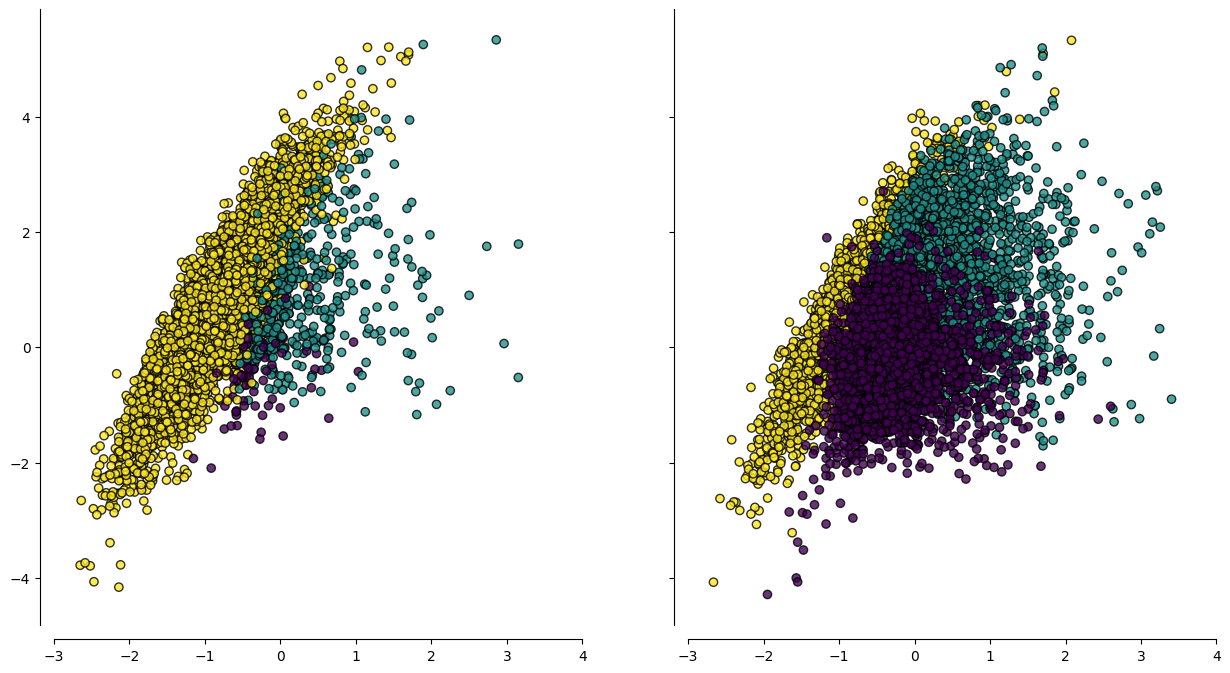

In [52]:
import matplotlib as mpl

# Set the style of plots
plt.style.use('default')
# mpl.rcParams["axes.facecolor"] = 'w'
# mpl.rcParams['grid.color'] = 'grey'
# mpl.rcParams['grid.alpha'] = 0.1

# mpl.rcParams['axes.linewidth'] = 0.3
# mpl.rcParams['axes.edgecolor'] = 'grey'

# mpl.rcParams['axes.spines.right'] = True
# mpl.rcParams['axes.spines.top'] = True

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
plot_resampling(X_synth, y_synth, ax=ax1)
plot_resampling(X_synth_cond, y_synth_cond, ax=ax2)
ax1.set_xlim([-3, 4])
plt.show()

In [38]:
plt.style.use('default')

In [46]:
pwd

'/Users/tonbadal/PycharmProjects/synthesized'